# Machine Predictive Maintenance
## Busness Context
I have a friend who working in a small team that taking care of water pump of a small area far from big town, there are 7 system failure in last year. Those failure cause huge problem to many people and also lead to some serious living problem of some family. The team can't see any pattern in the data when the system goes down, so they are not sure where to put more attention.

Since I believe in using data to solve problem, I ask him to provide available sensor data and hope that someone here can help.

## Content
The data are from all available sensor, all of them are raw value. Total sensor are 52 unit.

## Inspiration
I hope that we can predict next failure before it's happen

In [2]:
import datetime
import os
import re
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
import plotly.express as px
import cv2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
# from torchviz import make_dot
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from PIL import Image

import holoviews as hv
from holoviews import opts
#hv.extension('bokeh')
import json
#import shap

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from statsmodels.tsa.statespace.sarimax import SARIMAX #the big daddy

In [19]:
df = pd.read_csv('./data/pump_sensor.csv', index_col = 0)
df.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [20]:
df.tail()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
183829,2018-08-06 15:49:00,2.450637,49.782986,52.17014,44.965270,633.912048,77.73488,15.19821,16.652199,15.61777,...,49.73958,44.560180,42.24537,50.92593,51.79398,121.8171,52.662037,NaN,177.6620,NORMAL
183830,2018-08-06 15:50:00,2.459491,49.782986,52.12674,44.965275,643.402771,75.62521,15.01013,16.652200,15.66117,...,49.73958,43.981480,41.95602,50.34722,51.21528,118.3449,53.240740,NaN,178.2407,NORMAL
183831,2018-08-06 15:51:00,2.453588,49.782986,52.12674,44.965275,632.291626,73.56448,15.11863,16.565390,15.53096,...,49.47916,43.692130,41.66667,49.47917,51.21528,113.1366,52.372680,NaN,178.2407,NORMAL
183832,2018-08-06 15:52:00,2.455556,49.782986,52.17014,44.965275,630.937561,74.92599,15.04630,16.753470,15.69734,...,49.21875,43.402779,41.08796,48.90046,50.92593,111.4005,52.372680,NaN,177.6620,NORMAL
183833,2018-08-06 15:53:00,2.455556,49.782986,52.12674,44.965275,633.564819,74.20177,15.11863,16.702835,15.82031,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df['machine_status'].value_counts()

machine_status
NORMAL        169349
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64

data are collected from 2018-04-01 to 2018-08-06 with 1 data per sample. There are 7 broken data, 14477 recovering data and 169349 normal data.

In [22]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [23]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
timestamp,183834,2018-06-03 19:56:29.999999488,2018-04-01 00:00:00,2018-05-02 21:58:15,2018-06-03 19:56:30,2018-07-05 17:54:45,2018-08-06 15:53:00,NaN
sensor_00,173629.0,2.354912,0.0,2.441782,2.456539,2.499826,2.549016,0.450831
sensor_01,183468.0,47.226667,0.0,45.96354,47.74305,49.13194,56.72743,3.436749
sensor_02,183818.0,50.66115,33.15972,50.13021,51.5191,52.82118,56.03299,3.958369
sensor_03,183818.0,43.509936,31.64062,42.534721,43.923611,45.09549,48.22049,2.537209
sensor_04,183818.0,582.042509,2.798032,625.6945,632.2916,637.2686,800.0,156.19292
sensor_05,183818.0,73.775976,0.0,70.924885,76.560885,81.785702,99.99988,18.705292
sensor_06,179039.0,13.220725,0.014468,13.30295,13.56337,14.06973,22.25116,2.268711
sensor_07,178386.0,15.708749,0.0,15.74797,16.1603,16.24711,23.59664,2.388527
sensor_08,178730.0,15.089798,0.028935,15.14757,15.37182,15.65393,24.34896,2.213957


<Axes: >

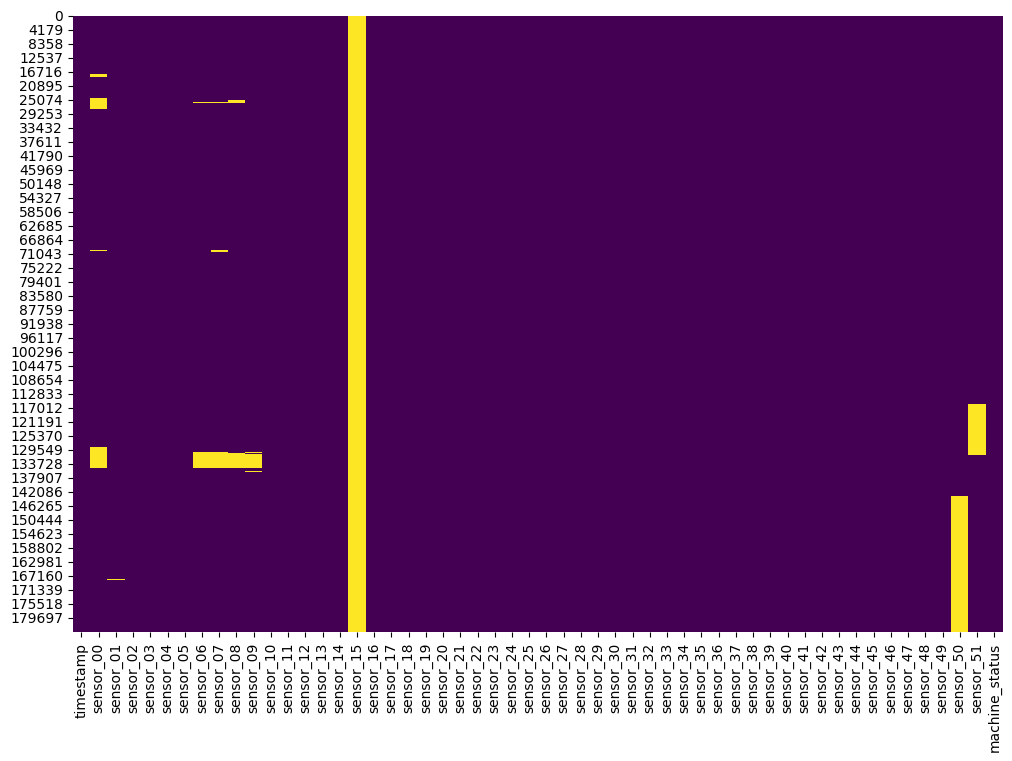

In [24]:
plt.figure(figsize = (12,8))
sns.heatmap(df.isna(), cbar = False, cmap = 'viridis')

There are 55 columns with 220320 recordings. Moreover, the measurements have different scales. There are na value in the data. All the data in sensor_15 are na. 20% of sensor_50 are na and they are all in Aug. 

In [25]:
df = df.drop(['sensor_00','sensor_15','sensor_50','sensor_51'],axis=1)

In [26]:
df = df.fillna(0)

In [27]:
def labeling(x):
    if x == 'NORMAL':
        return 0
    elif x == 'BROKEN':
        return 1
    else:
        return -1
df['machine_status'] = df['machine_status'].map(lambda x: labeling(x))

we label the target, setting normal to 0, broken to 1 and recovering to 2

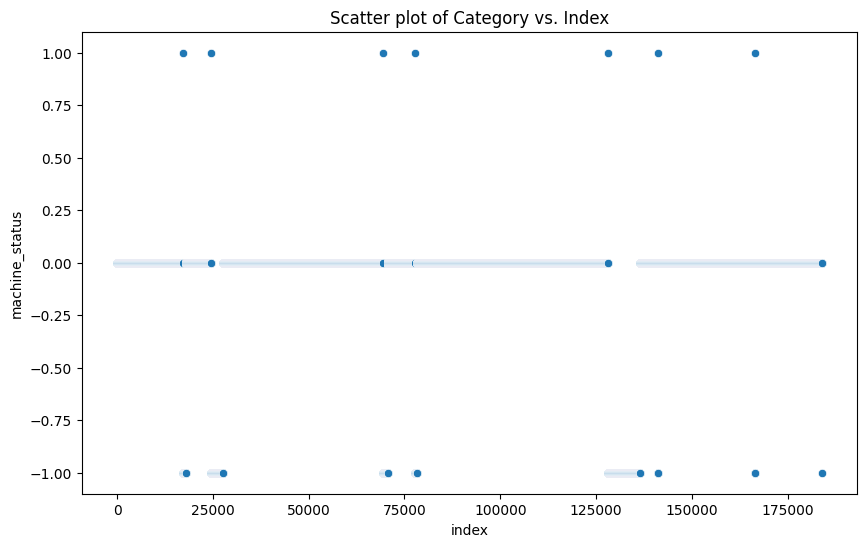

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.reset_index(), x='index', y='machine_status',  palette='viridis')  # y=0 仅为了使所有点在同一水平线上
plt.title("Scatter plot of Category vs. Index")
plt.show()

The figure above show the postion of the broken and recovering event. We can see that broken happen regular. Interesting is the recoverging happens right after and the length varies substantialy.

We have to be careful because the sensors do not specify the operating parameters they measure, such as B, pressure, temperature, flow, vibration, etc. However, it is very important to determine specifically and quickly which sensor becomes the decisive parameter for the operating status and operation of the pump.

In practice, pump systems are often equipped with multiple sensors for a single operating parameter (such as pressure, flow or temperature) for a variety of reasons, including safety, operational or system reliability or confidence in the automation equipment. This may be the reason why the measurement signals of some sensors overlap, as analyzed below.

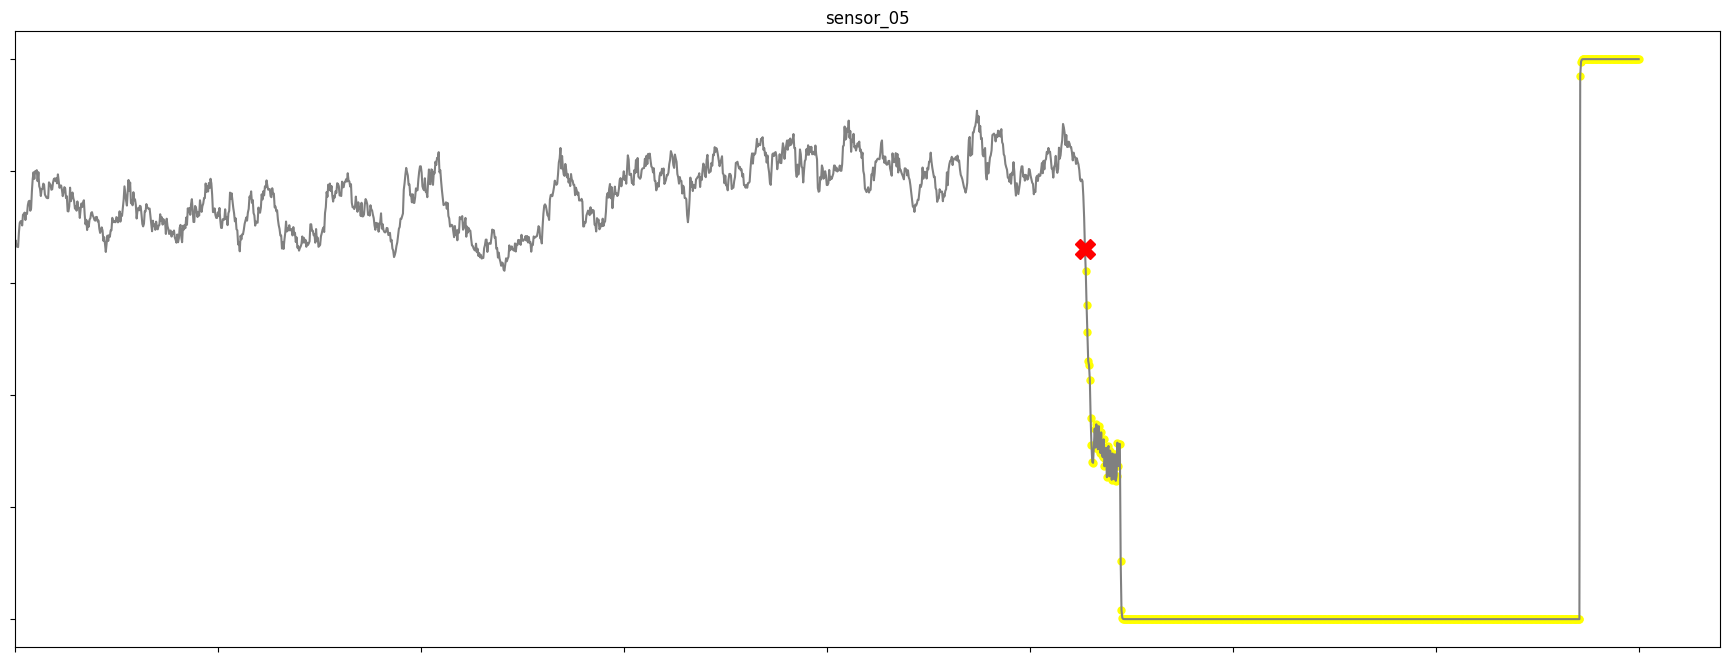

In [68]:
# n_features = df.shape[1]
# fig, axes = plt.subplots(n_features, 1, sharex=True, figsize=(20, 50))

# # 为每个特征绘制一个子图
# for i, col in enumerate(df.columns):
#     sns.lineplot(data=df, x=df.index, y=col, ax=axes[i])
#     axes[i].set_title(col)
#     axes[i].set_ylabel('Value')

# plt.tight_layout()
# plt.show()
s = 68000
e = 70000
sensor_cols = df.iloc[:,1:49]
broken_rows = df[df['machine_status']==1]
recovery_rows = df[df['machine_status']==-1]
normal_rows = df[df['machine_status']==0]
machine_status_col = df['machine_status']

sensor='sensor_05'
plot = plt.figure(figsize=(22,8))
plt.xlabel("")
plt.ylabel("")
plt.tick_params(labelbottom=False, labelleft=False)
plot = plt.plot(recovery_rows.loc[s:e,sensor], linestyle='none', marker='o', color='yellow', markersize=5)
plot = plt.plot(df.loc[s:e,sensor], color='grey')
plot = plt.plot(broken_rows.loc[s:e,sensor], linestyle='none', marker='X', color='red', markersize=14)
plot = plt.title(sensor)
plt.xlim((s,e+100))
#plt.show()
plt.savefig('seg.png', dpi = 600)
plt.show()

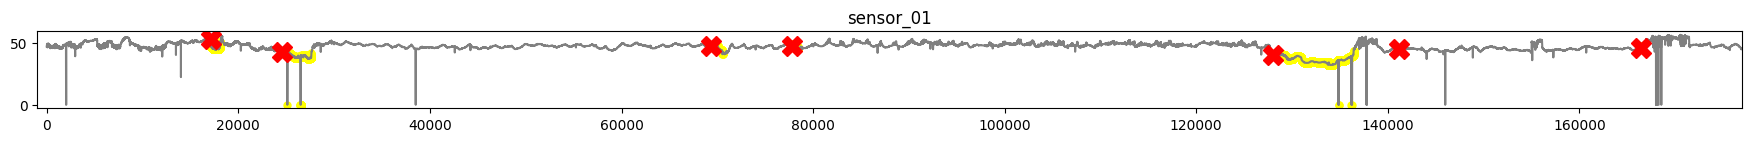

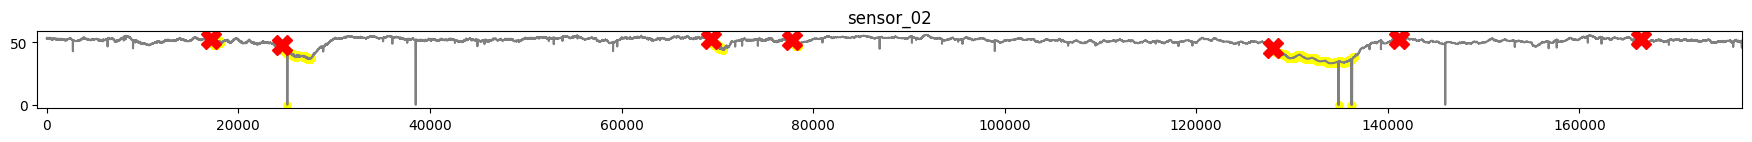

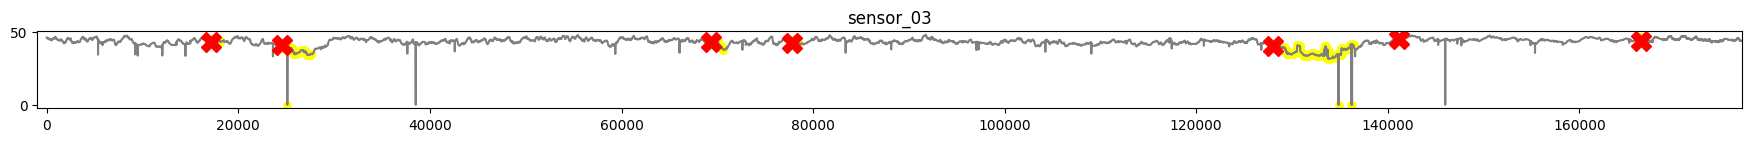

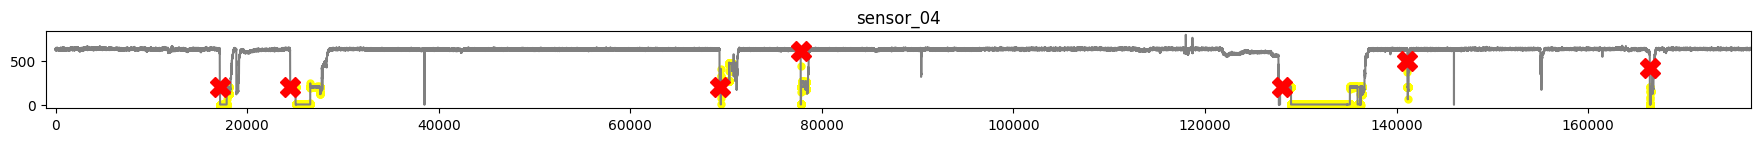

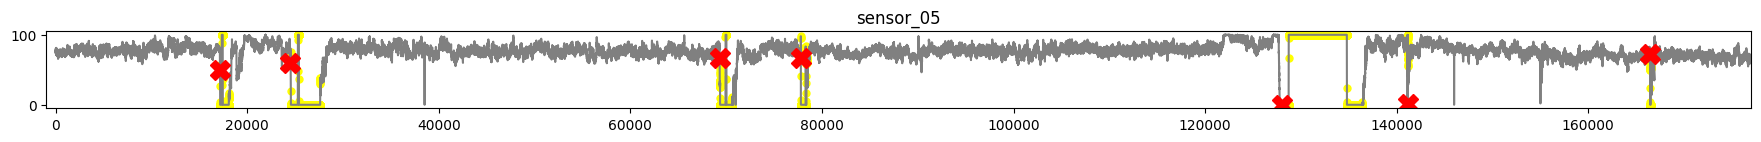

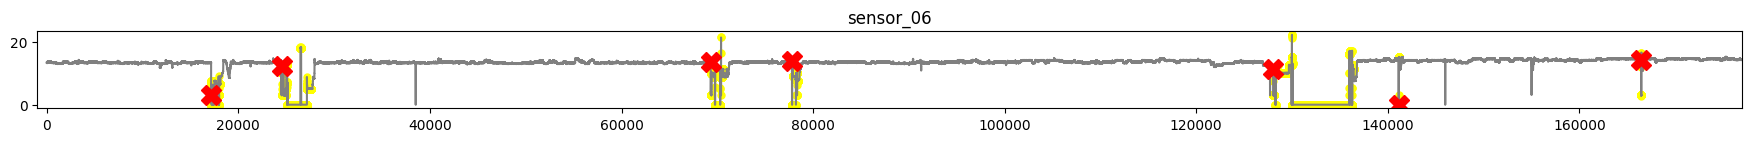

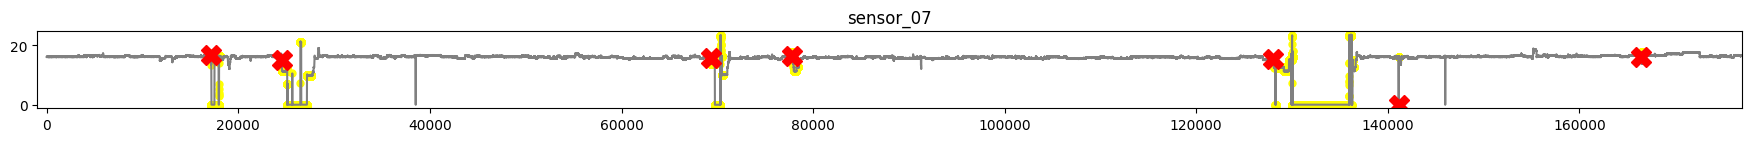

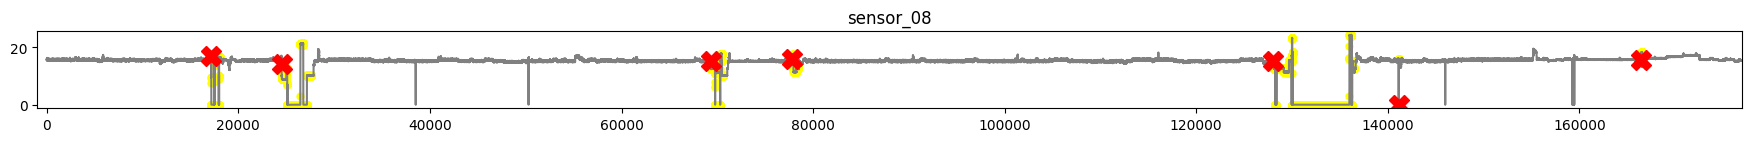

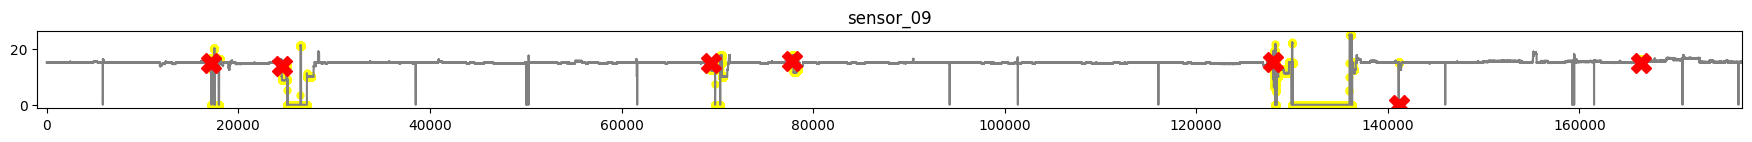

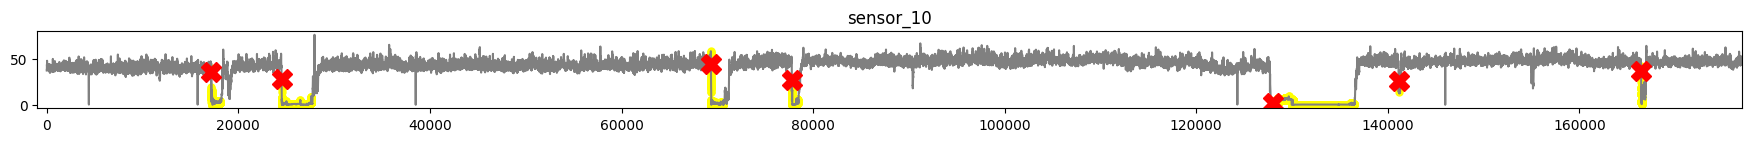

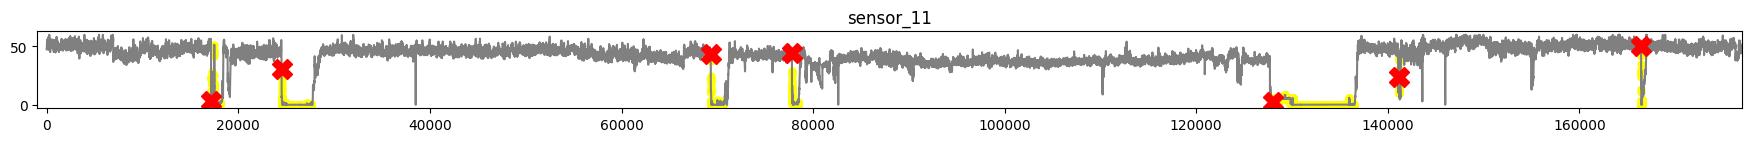

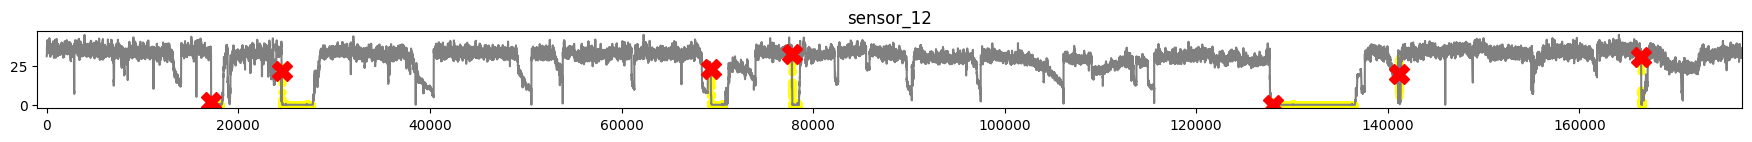

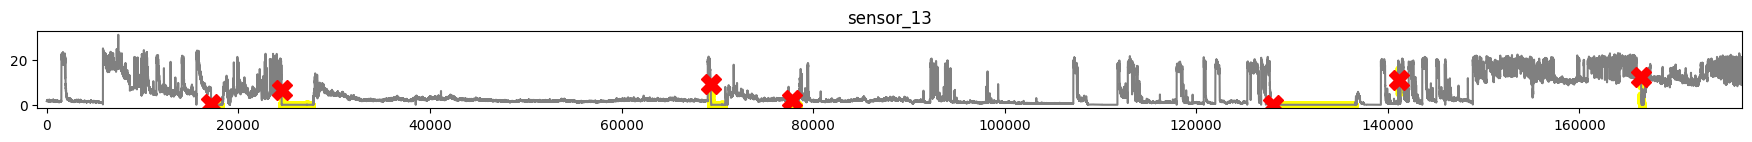

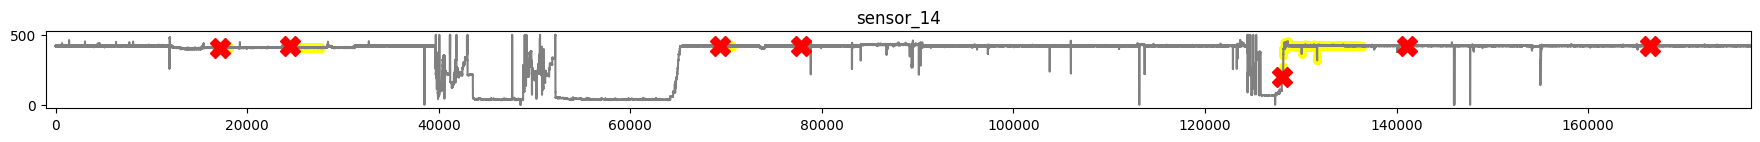

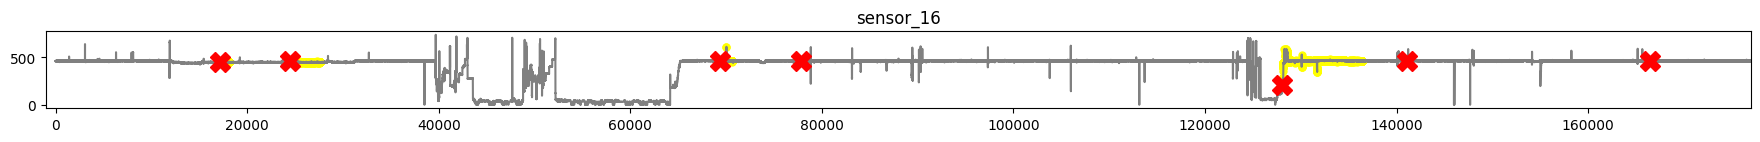

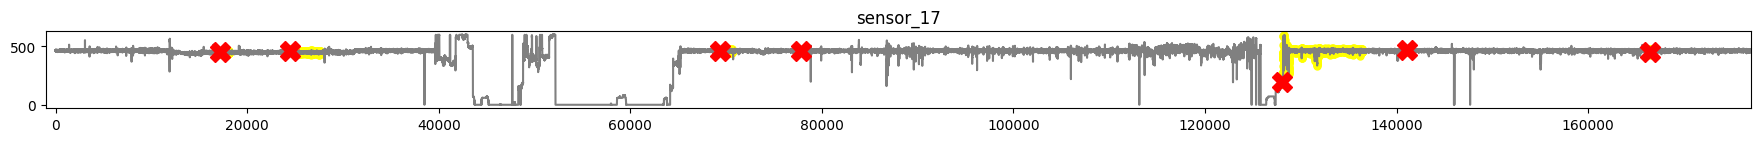

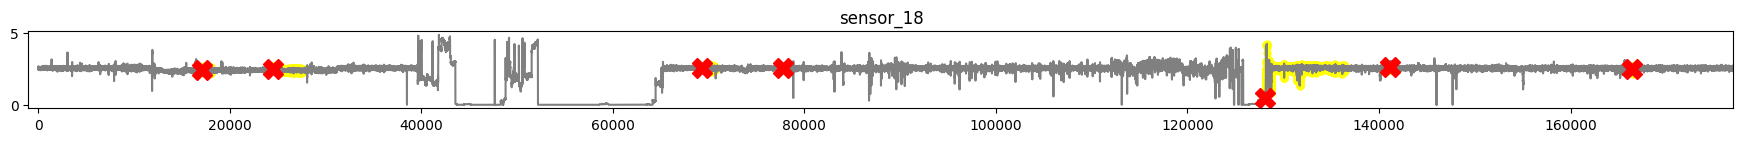

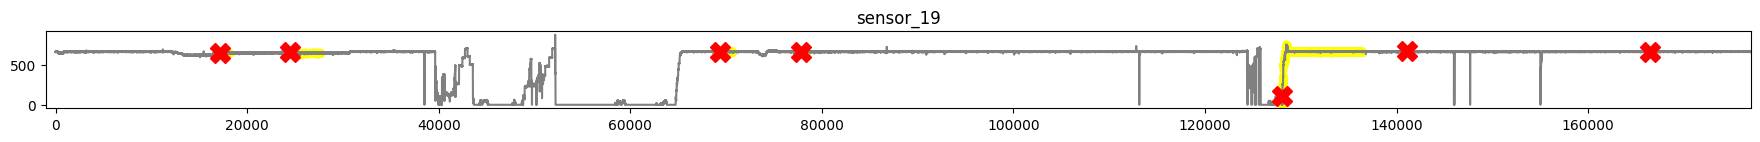

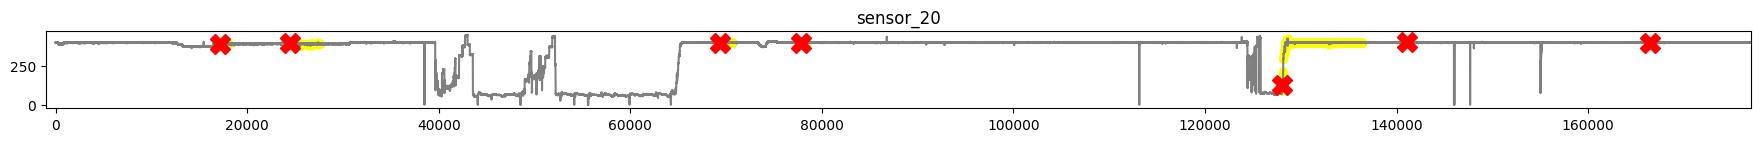

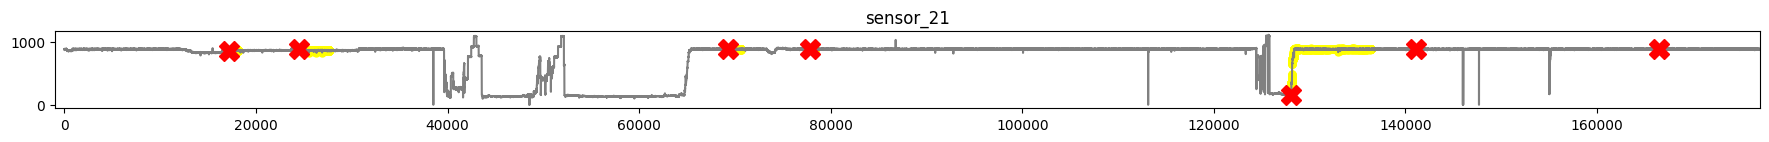

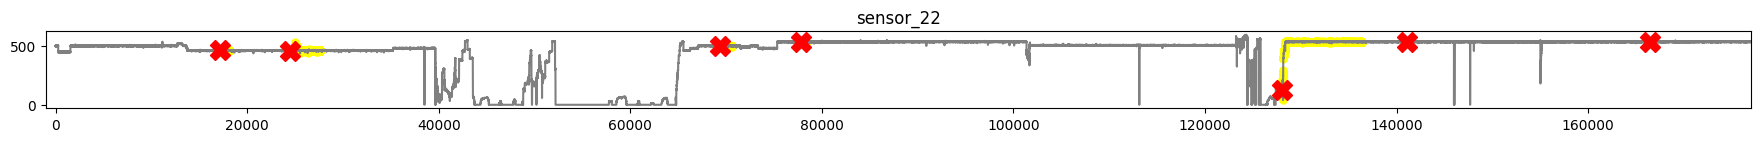

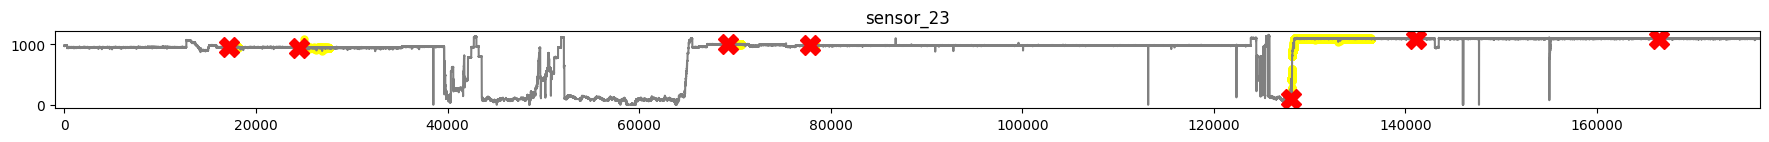

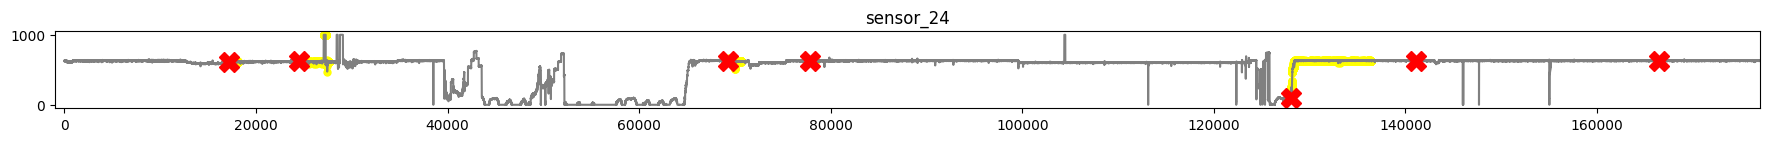

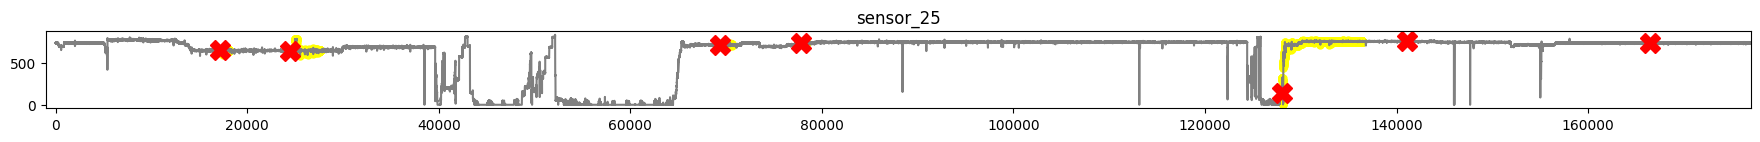

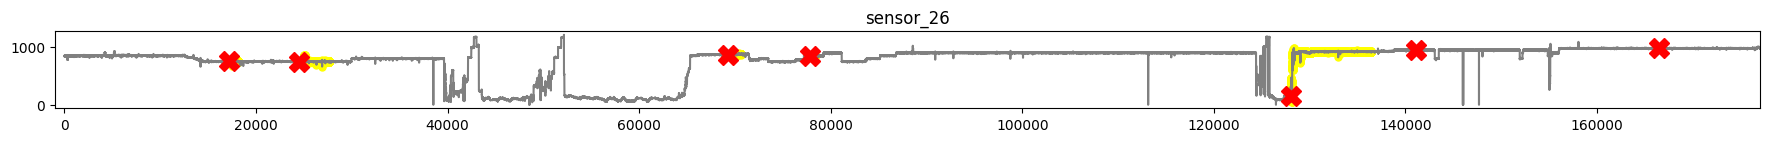

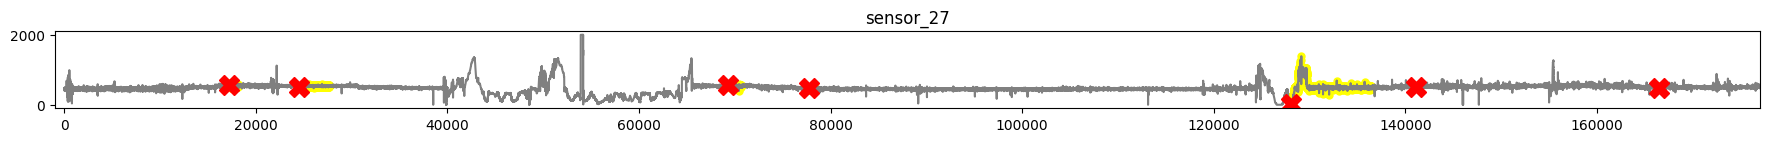

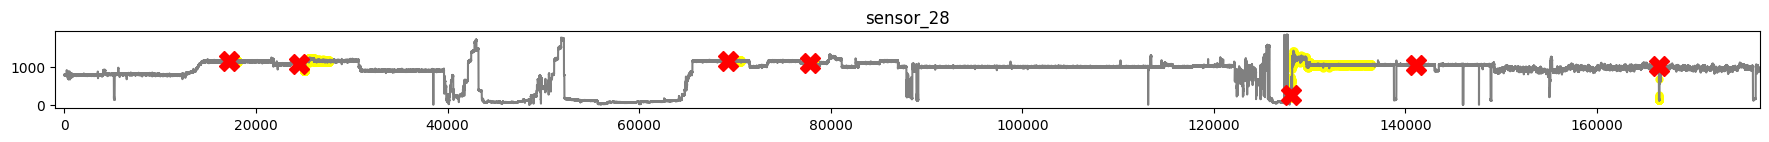

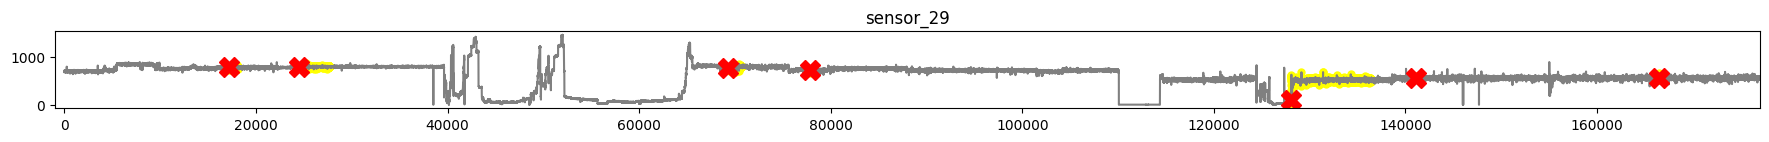

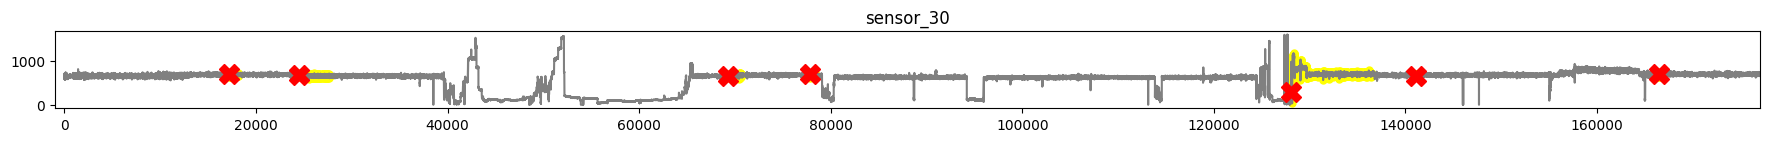

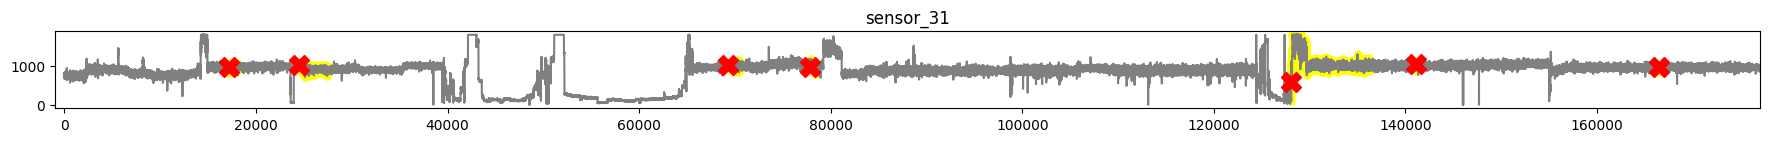

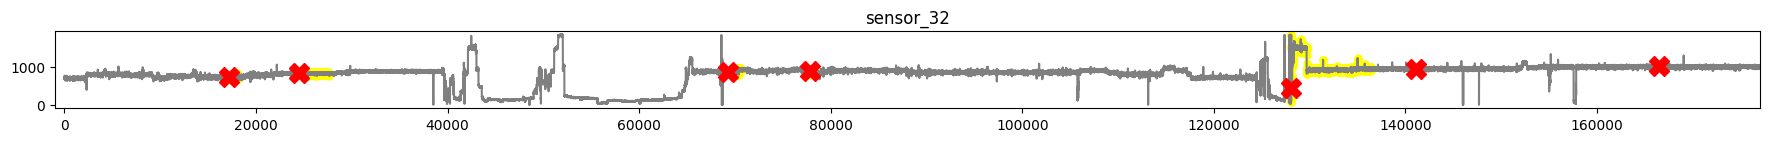

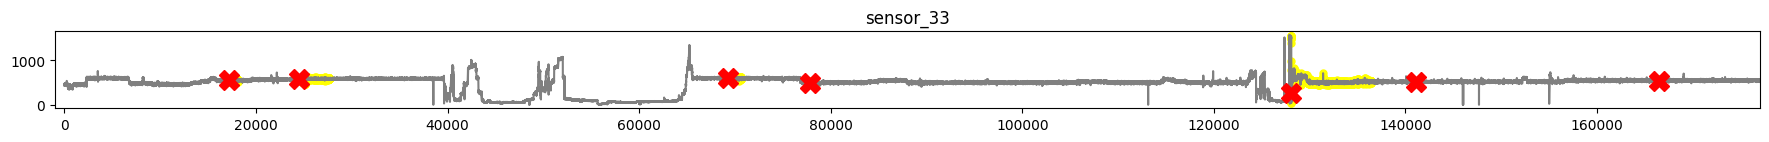

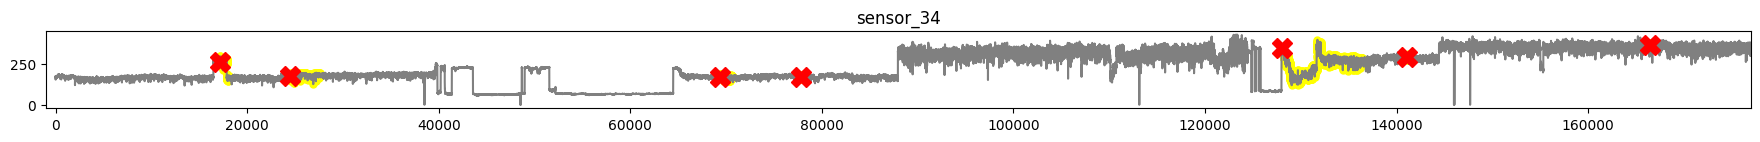

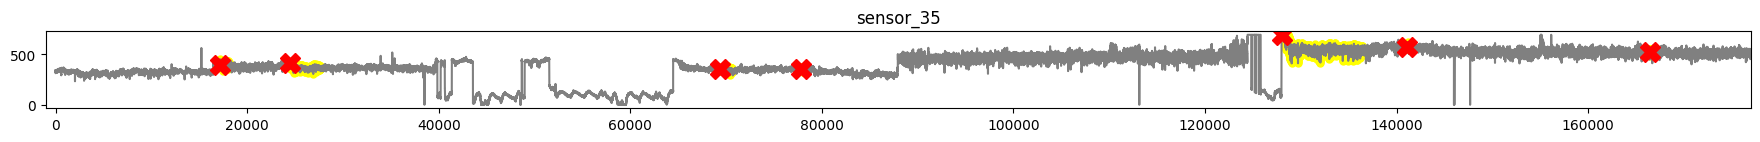

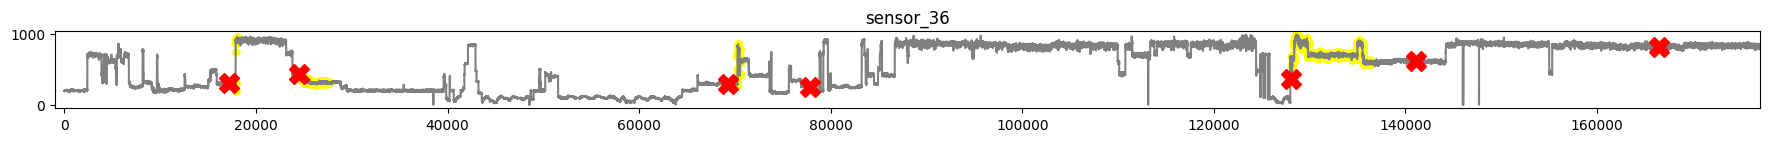

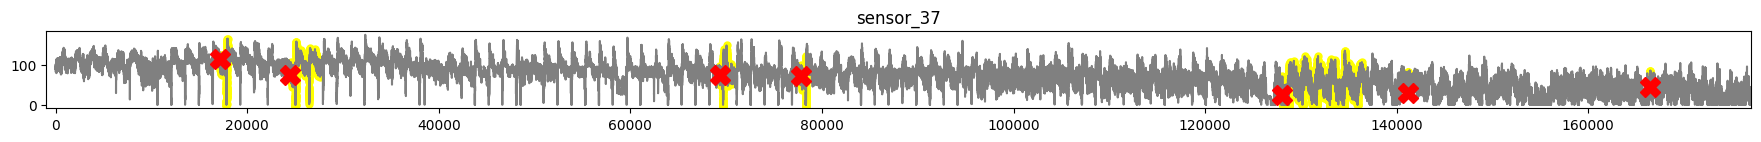

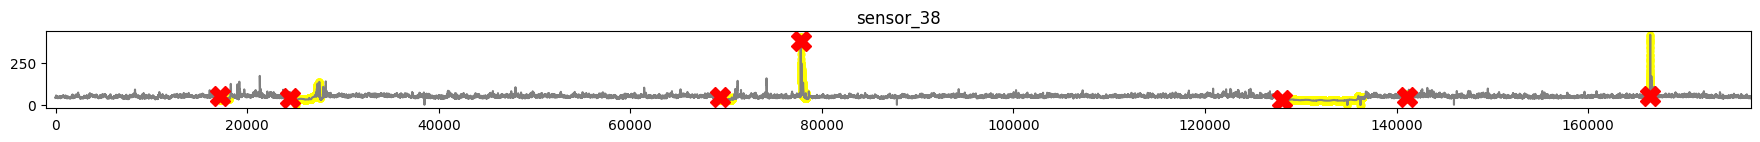

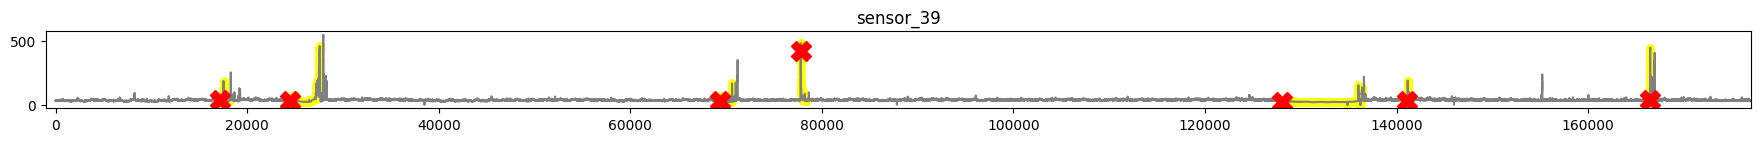

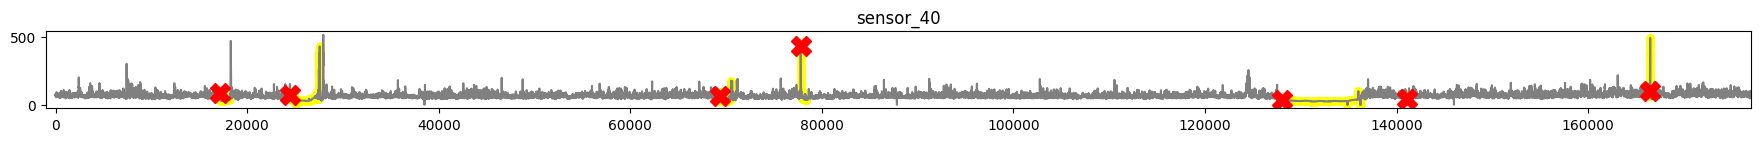

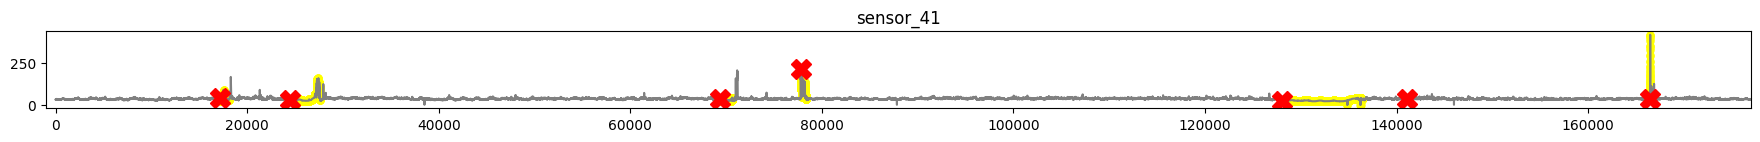

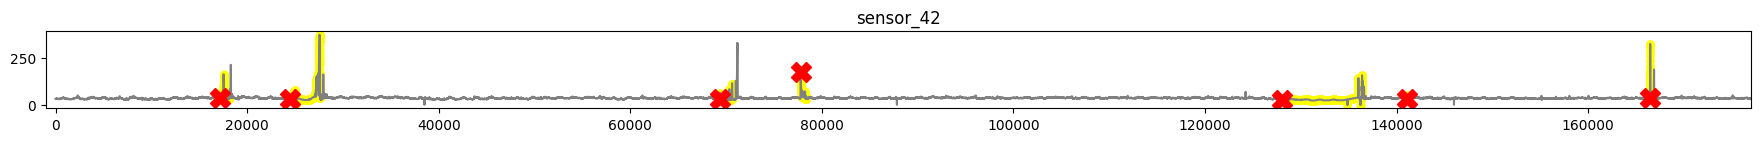

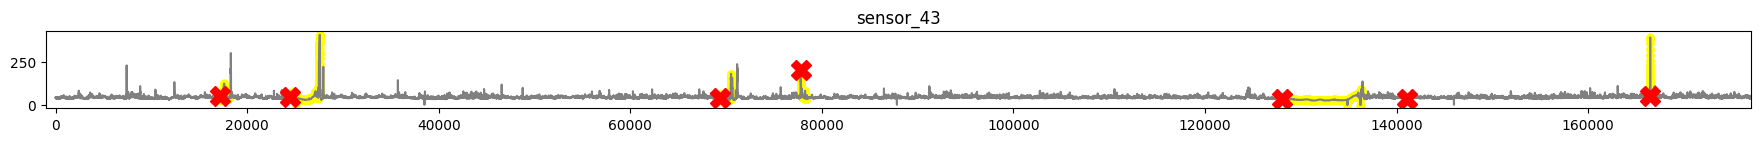

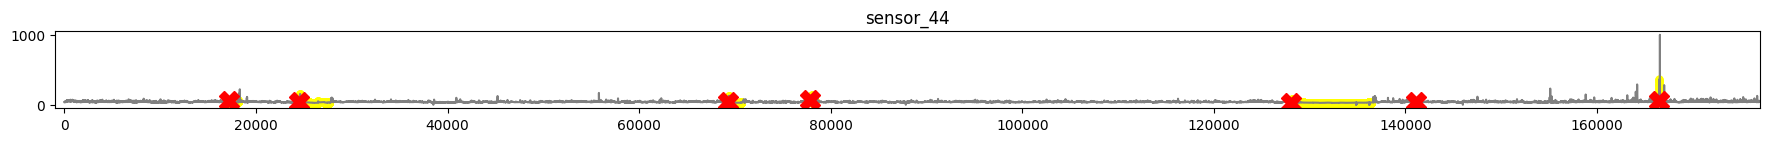

KeyboardInterrupt: 

In [16]:
# n_features = df.shape[1]
# fig, axes = plt.subplots(n_features, 1, sharex=True, figsize=(20, 50))

# # 为每个特征绘制一个子图
# for i, col in enumerate(df.columns):
#     sns.lineplot(data=df, x=df.index, y=col, ax=axes[i])
#     axes[i].set_title(col)
#     axes[i].set_ylabel('Value')

# plt.tight_layout()
# plt.show()
sensor_cols = df.iloc[:,1:49]
broken_rows = df[df['machine_status']==1]
recovery_rows = df[df['machine_status']==-1]
normal_rows = df[df['machine_status']==0]
machine_status_col = df['machine_status']

for sensor in sensor_cols:
    plot = plt.figure(figsize=(22,1))
    plot = plt.plot(recovery_rows[sensor], linestyle='none', marker='o', color='yellow', markersize=5)
    plot = plt.plot(df[sensor], color='grey')
    plot = plt.plot(broken_rows[sensor], linestyle='none', marker='X', color='red', markersize=14)
    plot = plt.title(sensor)
    plt.xlim((-1000,177000))
    plt.show();

In these figures, the 'x' is the position where the 'broken' happens and the yellow background signifies the recovering time periods.

<Axes: >

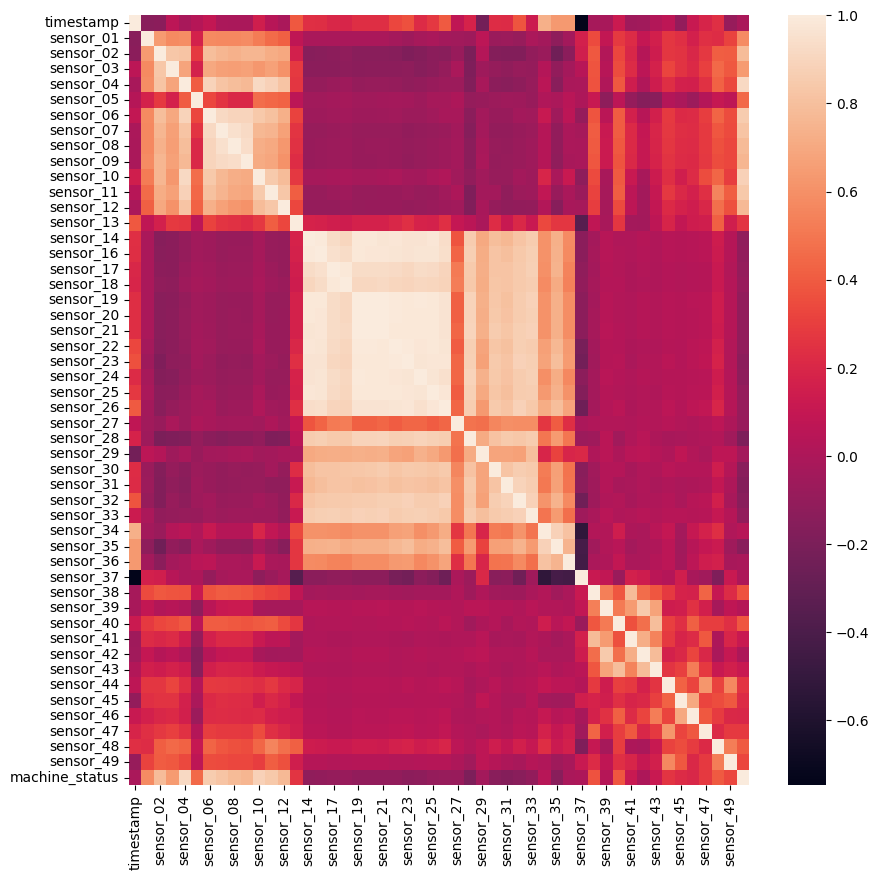

In [13]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr())

Above is the trend of each sensor. We can see that recovering have significant pattern in the some sensor. The value of some sensor are strongly correlated with each other. Some sensor are correlated to the target, however, it may deal to the large mount of the recovering data.

Since there are only 7 brocken samples, which means we need to train model with small number/unbalance data. Thereforce, if possible, we need to limit the number of the features to facilate the training of model, otherwise, the model will be overfit to the training data. According to the plot above, we assume that some sensors are installed in the same part of the machine and their value looks similar. We can either do the manual feature selection here or select the feature according to the model result at the end. Here we use the second method.

In addition, since the information about the art of the sensor are not given, it stays unclear for us whether the current high data resolution are needed. This can also be tested with the result of the prediction. 


The given problem formulation is ambiguous. For example, gap between the prediction and observation data, how long should we look forward? To this end, we set the problem as follow: To predict whether a 'borken' happens in the next day. To this end we first resample the data in hour and prepare the data for model training.

To simplify，we use all the data to train the scaler

In [14]:
def extract_y(window):
    if 1 in window.to_list():
        return 1
    return window.mode()

df_x = df.iloc[:, 1:-1].rolling(window = 120, step = 60).mean()
df_y = df.iloc[:, -1].rolling(window = 120, step = 60).apply(extract_y)

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_x = pd.DataFrame(scaler.fit_transform(df_x))

In [25]:
def prepare_data(df_x, df_y, window_size=30, forecast_period=30):
    """
    准备训练数据。
    
    df: 原始DataFrame
    window_size: 输入数据的时间窗口大小
    forecast_period: 预测的未来时间段
    
    返回: X, y
    """
    assert(len(df_x) == len(df_y))
    
    X, y = [], []

    # 遍历每个时间窗口
    for i in range(len(df_x) - window_size - forecast_period + 1):
        # 选取窗口数据
        wind_x = df_x.iloc[i:i+window_size].fillna(method = 'bfill')
        wind_y = df_y.iloc[i:i+window_size].fillna(method = 'bfill')
        
        # 检查窗口内是否有故障
        if 1 not in wind_y and -1 not in wind_y:
            X.append(wind_x.values)
            
            # 检查预测期内是否有故障
            forecast_data = df_y.iloc[i+window_size:i+window_size+forecast_period]
            y.append(1 if 1 in forecast_data.values else 0)
            
    X = np.stack(X)
    y = np.stack(y)
    return X, y

window_size = 24
forecast_period = 24 * 7

X, y = prepare_data(df_x, df_y, window_size, forecast_period)


In [26]:
X.shape

(2873, 24, 48)

In [27]:
pd.Series(y).value_counts()

0    1764
1    1109
Name: count, dtype: int64

We can see that, after the data extraction, we get a 3 dimension input data, with 24 is the length of the window and 48 the number of the sensor. In addition, instead of 7, we got 24*7 = 168 broken label. The reason is the change of the prediction target. However, it also bring one problem, most of the data look similar. To evaluate the performance of the train model, we need to split the data into training and testing set. We need to make sure that the similar data will not be in both training and testting data. Thereforce, we can not split the data randomly. I suggestion is to split the data according to time.

In [28]:
def evaluate_ml_model(model, n, X, y):
    """
    the model should implement the fit and prediction function
    n is the number of fold in the cross validation. 
    Since we only use ml model in this function, we need to flatten the data at the beginning
    """
    X = X.reshape([X.shape[0], -1])
    
    df_rsl = pd.DataFrame(columns = ['n fold', 'accuracy train', 'accuracy test', 'recall train', 'recall test', 'precision train', 'precision test'])
    
    block_size = int(X.shape[0]/n)+2
    
    if n == 1:
        print("n should be larger then one, please reset the n")
    
    counter = 0
    for i in np.arange(0, X.shape[0], block_size):
        if i == 0:
            X_train = X[block_size:]
            y_train = y[block_size:]
            X_test = X[:block_size]
            y_test = y[:block_size]
            
        elif (X.shape[0] - i) < block_size:
            X_train = X[:i]
            y_train = y[:i]
            X_test = X[i:]
            y_test = y[i:]
        
        else:
            X_train1 = X[:i]
            X_train2 = X[i+block_size:]
            y_train1 = y[:i]
            y_train2 = y[i+block_size:]
            X_train = np.concatenate([X_train1, X_train2], axis = 0)
            y_train = np.concatenate([y_train1, y_train2], axis = 0)
            
            X_test = X[i:i+block_size]
            y_test = y[i:i+block_size]
        
        # whether 'broken' data in the test set
        if len(pd.Series(y_test).value_counts()) == 1:
            print("There is no brocken data in the test set.")
            continue
        
        if len(pd.Series(y_train).value_counts()) == 1:
            print("There is no brocken data in the train set.")
            continue
        
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        acc_train = accuracy_score(y_train, pred_train)
        acc_test = accuracy_score(y_test, pred_test)
        
        recall_train = recall_score(y_train, pred_train)
        recall_test = recall_score(y_test, pred_test)
        
        precision_train = precision_score(y_train, pred_train)
        precision_test = precision_score(y_test, pred_test)
        
        df_rsl.loc[counter, 'n fold'] = counter
        df_rsl.loc[counter, 'accuracy train'] = acc_train
        df_rsl.loc[counter, 'accuracy test'] = acc_test
        df_rsl.loc[counter, 'recall train'] = recall_train
        df_rsl.loc[counter, 'recall test'] = recall_test
        df_rsl.loc[counter, 'precision train'] = precision_train
        df_rsl.loc[counter, 'precision test'] = precision_test
        
        counter += 1
    
    return df_rsl

As discuss above, we can see that the accuracy, recall and precision are one and in test set the score are terrible, which means the model overfit to the training set. The reason for getting 93% accuracy in the test set is the unbalance of the data. To improve the generability of the model, we need to 1. limit the capacity of the given model. 2. preprocess the information given to the model.

There are multiple method that can fulfill the above requirement, here we make use of the greedy algorithm

Concretely, starting from single feature, in each round, we walk through all the feature and add the best feature, which can bring improvement in the model performance, to the target feature list. The algorithm ends when no improvement bring.

In [68]:
def greedy_search(model, X, y):
    df_rsl = pd.DataFrame(columns = ['index', 'features', 'accuracy train', 'accuracy test', 'recall train', 'recall test', 'precision train', 'precision test'])
    
    out = []
    counter = 0
    best = 0
    
    while True:
        flag = False
        for i in range(X.shape[2]):
            if i in out:
                continue

            cands = out + [i]
            score = evaluate_ml_model(model, 4, X[:, :, i], y)[['accuracy train', 'accuracy test', 'recall train', 'recall test', 'precision train', 'precision test']].mean()

            if best < score['recall test']:
                best = score['recall test']
                tmp = i
                flag = True

            df_rsl.loc[counter, 'index'] = counter
            df_rsl.loc[counter, 'features'] = cands
            df_rsl.loc[counter, ['accuracy train', 'accuracy test', 'recall train', 'recall test', 'precision train', 'precision test']] = score
            
            counter += 1
        
        if flag:
            out.append(tmp)
        else:
            break
    
    return df_rsl

def plot_top_ten_result(df_rsl, name = None):
    df_tmp = df_rsl.sort_values('recall test', ascending = False).head(10)
    df_tmp[['accuracy train', 'accuracy test', 'recall train', 'recall test', 'precision train', 'precision test']] = df_tmp[['accuracy train', 'accuracy test', 'recall train', 'recall test', 'precision train', 'precision test']].astype(float)
    df_tmp['features'] = df_tmp['features'].astype(str)
    
    df_melted = pd.melt(df_tmp, id_vars=['features'], value_vars=['recall test', 'precision test'], 
                        var_name='Metric', value_name='Value')

    # 使用 seaborn 绘制柱状图
    plt.figure(figsize=(10, 6))
    sns.barplot(x='features', y='Value', hue='Metric', data=df_melted, palette='pastel')
    if name is not None:
        plt.title(name)
    else:
        plt.title('Recall and Precision of Features')
    plt.show()

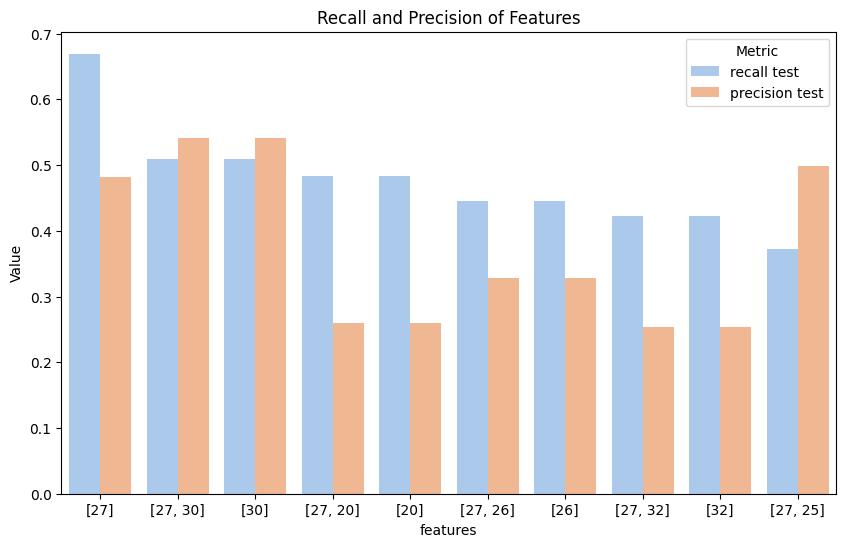

In [69]:
model = SVC()
df_rsl = greedy_search(model, X, y)
plot_top_ten_result(df_rsl)

The figure present the top ten result gettting from the result. Since the target is to show the ability of the ML model, we didn't use it to select the features, thereforce, we didn't use the validation set. Here is the result of the test set. We can see that with SVC classifier, sensor 27 along performance well. The recall is about 65% with about 50% precision. It means that, if there are 10 broken data. The model may make about 14 warnning and 7 of the 14 hit the problem. 

We also test the performance of some other model in the following:

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

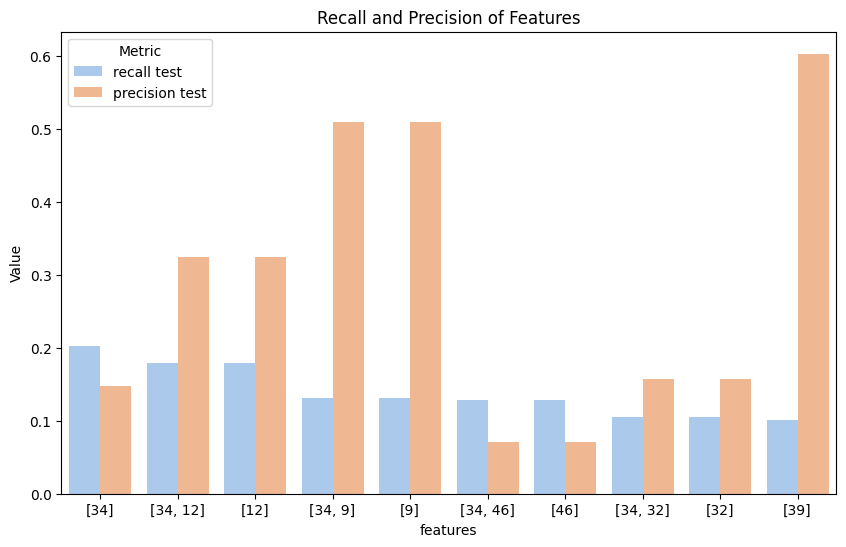

In [71]:
model = LogisticRegression()
df_rsl = greedy_search(model, X, y)
plot_top_ten_result(df_rsl)

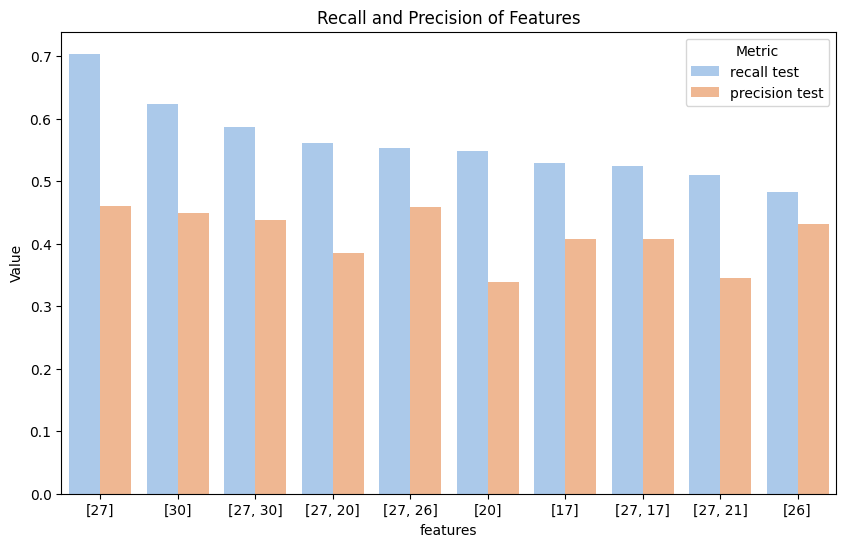

In [72]:
model = DecisionTreeClassifier()
df_rsl = greedy_search(model, X, y)
plot_top_ten_result(df_rsl)

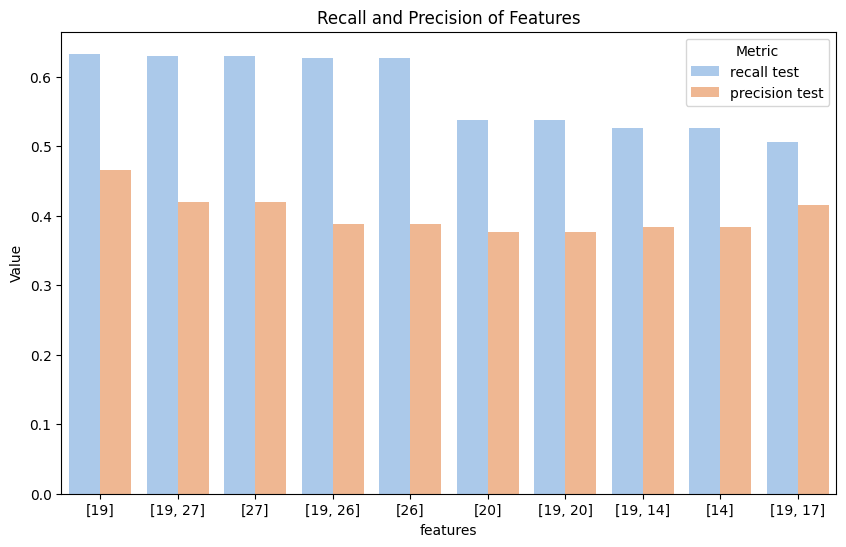

In [73]:
model = KNeighborsClassifier()
df_rsl = greedy_search(model, X, y)
plot_top_ten_result(df_rsl)

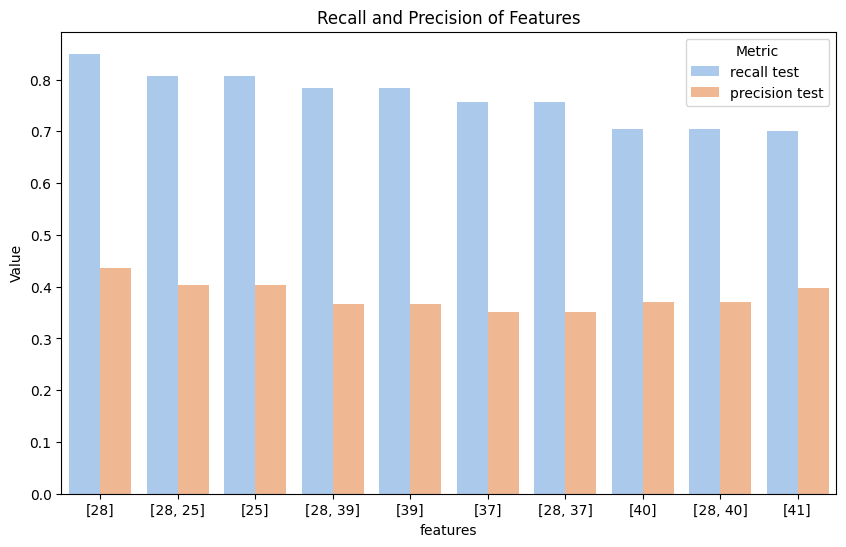

In [74]:
model = GaussianNB()
df_rsl = greedy_search(model, X, y)
plot_top_ten_result(df_rsl)

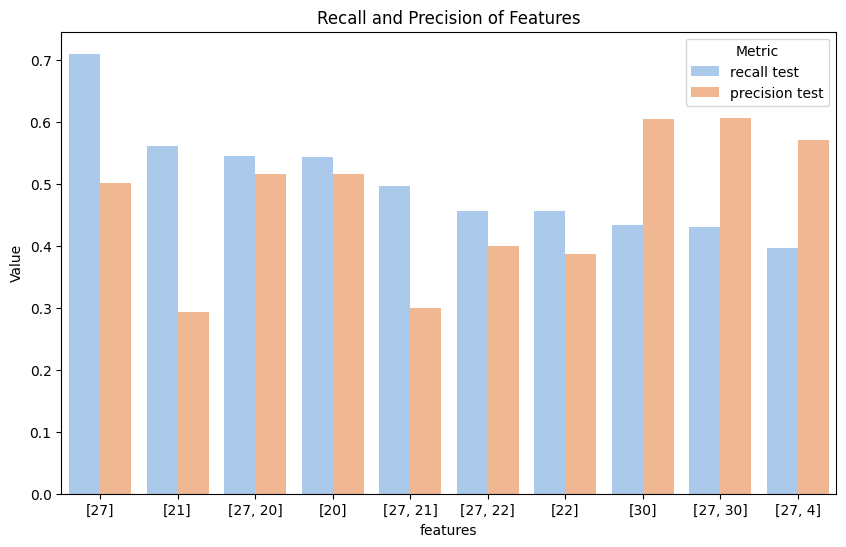

In [75]:
model = RandomForestClassifier()
df_rsl = greedy_search(model, X, y)
plot_top_ten_result(df_rsl)

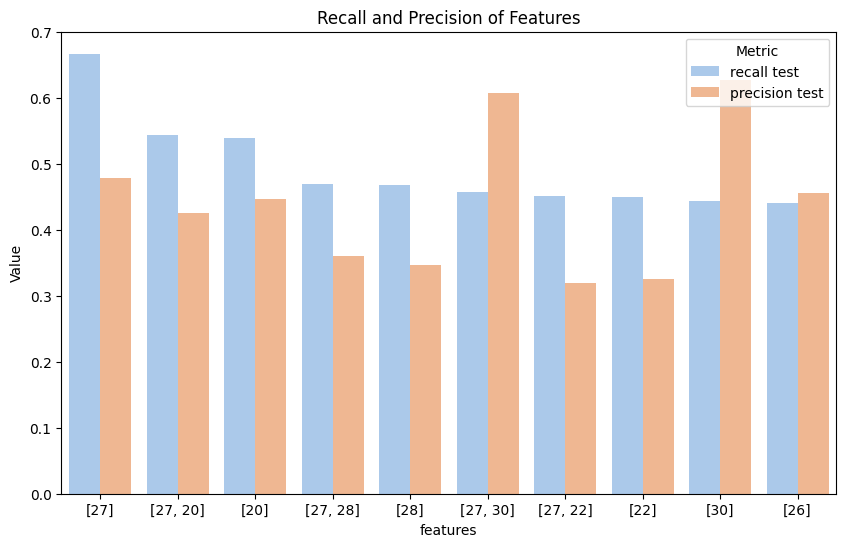

In [76]:
model = ExtraTreesClassifier()
df_rsl = greedy_search(model, X, y)
plot_top_ten_result(df_rsl)

In general, the Decision tree model work best. The reason why decision tree work better then the ensemble method RandomForest and ExtraTree can deal to the overfitting of the model. The best model achieve 0.7 recall and 0.5 precision. In addition, we found that for different model the features regards important are different, for example KNN finds sensor 19 important, but all the other models don't. In contrast, most models regard sensor 27 and 30 as important.